In [3]:
# ============================================================================
# CELL 0: IMPORT LIBRARIES & CONFIGURATION (KAGGLE)
# ============================================================================

import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import (Input, LSTM, GRU, Dense, Dropout, 
                                      Concatenate, Bidirectional, Reshape,
                                      MultiHeadAttention, LayerNormalization, Flatten)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

warnings.filterwarnings("ignore")

# Enable mixed precision for faster training on GPU
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("✓ Mixed precision training enabled")
except:
    print("⚠ Mixed precision not available, using default precision")

# Configuration
CONFIG = {
    'data_path': '/kaggle/input/misshanoi/Impute_misvalues_hanoi.csv',  # KAGGLE PATH
    'output_path': '/kaggle/working',  # KAGGLE OUTPUT PATH
    'window': 3,              # eDTWBI window size (optimized)
    'k_best': 2,              # Number of best patterns to use
    'cosine_threshold': 0.7,  # Cosine similarity threshold
    'sequence_length': 20,    # LSTM/GRU/Transformer input length
    'epochs': 50,             # Training epochs
    'batch_size': 128,        # Batch size (optimized for GPU)
    'validation_split': 0.15, # Validation split ratio
    'random_seed': 42,        # Random seed for reproducibility
    'cache_file': '/kaggle/working/edtwbi_cache.pkl',  # KAGGLE CACHE PATH
}

np.random.seed(CONFIG['random_seed'])
tf.random.set_seed(CONFIG['random_seed'])

print(f"Data path: {CONFIG['data_path']}")
print(f"Output path: {CONFIG['output_path']}")

2025-10-29 01:41:06.631354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761702066.868273      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761702066.938528      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ Mixed precision training enabled
Data path: /kaggle/input/misshanoi/Impute_misvalues_hanoi.csv
Output path: /kaggle/working


In [4]:
# ============================================================================
# CELL 1: DATA LOADING & PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("STEP 1: DATA LOADING & PREPROCESSING")
print("="*80)

# Load data
df = pd.read_csv(CONFIG['data_path'])
original = df['Average'].copy()
waterlevel = df['Waterlevel'].to_numpy(float)

print(f"✓ Data loaded: {len(original)} records")
print(f"  - Missing values in Average: {original.isna().sum()} ({original.isna().sum()/len(original)*100:.1f}%)")
print(f"  - Complete values in Waterlevel: {waterlevel.shape[0]}")


STEP 1: DATA LOADING & PREPROCESSING
✓ Data loaded: 29224 records
  - Missing values in Average: 25910 (88.7%)
  - Complete values in Waterlevel: 29224


In [5]:
# ============================================================================
# CELL 2: UTILITY FUNCTIONS - GAP DETECTION & DTW
# ============================================================================

def find_gaps(arr):
    """Detect all missing value segments (gaps) in array"""
    gaps, inside = [], False
    for i, v in enumerate(arr):
        if np.isnan(v):
            if not inside:
                g0 = i
                inside = True
        else:
            if inside:
                g1 = i - 1
                gaps.append((g0, g1))
                inside = False
    if inside:
        gaps.append((g0, len(arr) - 1))
    return gaps


def dtw_distance(s1, s2, window_size=None):
    """
    Optimized DTW distance calculation with Sakoe-Chiba band constraint
    Reduces complexity from O(n²) to O(n*window_size)
    """
    n, m = len(s1), len(s2)
    if window_size is None:
        window_size = max(n, m)
    
    dtw = np.full((n+1, m+1), np.inf)
    dtw[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(max(1, i-window_size), min(m+1, i+window_size)):
            cost = abs(s1[i-1] - s2[j-1])
            dtw[i, j] = cost + min(dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1])
    
    return dtw[n, m]

In [6]:
# ============================================================================
# CELL 3: eDTWBI CONTEXT EXTRACTION (Optimized with caching)
# ============================================================================

print("\n" + "="*80)
print("STEP 2: eDTWBI CONTEXT EXTRACTION")
print("="*80)

def edtwbi_context(arr, ref, gap_start, gap_end, window=3, k_best=2, 
                   cosine_threshold=0.7, dtw_radius=3):
    """
    Extract pattern context using eDTWBI (Enhanced DTW Block Imputation)
    Optimized with DTW window constraint for faster computation
    """
    gap_len = gap_end - gap_start + 1
    left_context = ref[max(0, gap_start-window):gap_start]
    right_context = ref[gap_end+1:gap_end+window+1]
    
    candidates = []
    search_range = min(len(ref) - gap_len - window, 
                      max(500, len(ref)//10))  # Limit search range
    
    for idx in range(window, search_range):
        cand_l = ref[idx-window:idx]
        cand_g = ref[idx:idx+gap_len]
        cand_r = ref[idx+gap_len:idx+gap_len+window]
        
        if np.isnan(cand_g).any() or np.isnan(cand_l).any() or np.isnan(cand_r).any():
            continue
        
        # Cosine similarity filtering (fast pre-filtering)
        sim_l = 1 - cosine(left_context, cand_l) if len(left_context) == window else 0
        sim_r = 1 - cosine(right_context, cand_r) if len(right_context) == window else 0
        avg_sim = (sim_l + sim_r) / 2
        
        if avg_sim >= cosine_threshold:
            # DTW distance with window constraint (optimized)
            dist = dtw_distance(left_context, cand_l, window_size=dtw_radius) + \
                   dtw_distance(right_context, cand_r, window_size=dtw_radius)
            candidates.append((dist, cand_g, cand_l, cand_r))
    
    if candidates:
        candidates.sort(key=lambda x: x[0])
        best_gaps = [x[1] for x in candidates[:k_best]]
        context_feature = np.concatenate([
            *candidates[0][2:4],
            [np.mean(best_gaps), np.std(best_gaps)]
        ])
        fill_val = np.mean(best_gaps, axis=0)
    else:
        context_feature = np.zeros(window * 2 + 2)
        fill_val = np.full(gap_len, np.nanmean(ref))
    
    return context_feature, fill_val


# Check cache first
if os.path.exists(CONFIG['cache_file']):
    print(f"✓ Loading cached eDTWBI results from {CONFIG['cache_file']}")
    with open(CONFIG['cache_file'], 'rb') as f:
        context_vectors, imputed_full = pickle.load(f)
else:
    print("⚠ Computing eDTWBI context (first run, will be cached)...")
    gaps = find_gaps(original)
    context_vectors = {}
    imputed_full = original.to_numpy(float).copy()
    
    for i, (start, end) in enumerate(gaps):
        if (i + 1) % max(1, len(gaps)//10) == 0:
            print(f"  Progress: {i+1}/{len(gaps)} gaps processed")
        
        ctx, fill = edtwbi_context(original.to_numpy(float), waterlevel,
                                  start, end, CONFIG['window'], CONFIG['k_best'],
                                  CONFIG['cosine_threshold'])
        imputed_full[start:end+1] = fill
        context_vectors[(start, end)] = ctx
    
    # Cache results
    with open(CONFIG['cache_file'], 'wb') as f:
        pickle.dump((context_vectors, imputed_full), f)
    print(f"✓ eDTWBI cache saved: {CONFIG['cache_file']}")

print(f"✓ Context extraction complete: {len(context_vectors)} gaps processed")



STEP 2: eDTWBI CONTEXT EXTRACTION
⚠ Computing eDTWBI context (first run, will be cached)...
  Progress: 331/3315 gaps processed
  Progress: 662/3315 gaps processed
  Progress: 993/3315 gaps processed
  Progress: 1324/3315 gaps processed
  Progress: 1655/3315 gaps processed
  Progress: 1986/3315 gaps processed
  Progress: 2317/3315 gaps processed
  Progress: 2648/3315 gaps processed
  Progress: 2979/3315 gaps processed
  Progress: 3310/3315 gaps processed
✓ eDTWBI cache saved: /kaggle/working/edtwbi_cache.pkl
✓ Context extraction complete: 3315 gaps processed


In [7]:
# ============================================================================
# CELL 4: DATA NORMALIZATION & DATASET PREPARATION
# ============================================================================
from sklearn.preprocessing import MinMaxScaler

print("\n" + "="*80)
print("STEP 3: DATA NORMALIZATION & DATASET PREPARATION")
print("="*80)

sc_seq = MinMaxScaler()
sc_ref = MinMaxScaler()
seq_norm = sc_seq.fit_transform(imputed_full.reshape(-1,1)).flatten()
ref_norm = sc_ref.fit_transform(waterlevel.reshape(-1,1)).flatten()
context_dim = len(next(iter(context_vectors.values()))) if context_vectors else 12

gaps = find_gaps(original)
X_seq, X_ref, X_ctx, y = [], [], [], []

for i in range(CONFIG['sequence_length'], len(seq_norm)):
    seq = seq_norm[i-CONFIG['sequence_length']:i]
    ref = ref_norm[i-CONFIG['sequence_length']:i]
    cur_ctx = np.zeros(context_dim)
    
    for (s, e) in gaps:
        if s <= i <= e:
            cur_ctx = context_vectors.get((s, e), np.zeros(context_dim))
            break
    
    X_seq.append(seq)
    X_ref.append(ref)
    X_ctx.append(cur_ctx)
    y.append(seq_norm[i])

X_seq = np.array(X_seq, dtype=np.float32)
X_ref = np.array(X_ref, dtype=np.float32)
X_ctx = np.array(X_ctx, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Train/test split (temporal split, not random)
split_idx = int(0.8 * len(X_seq))
X_seq_tr, X_ref_tr, X_ctx_tr, y_tr = X_seq[:split_idx], X_ref[:split_idx], X_ctx[:split_idx], y[:split_idx]
X_seq_te, X_ref_te, X_ctx_te, y_te = X_seq[split_idx:], X_ref[split_idx:], X_ctx[split_idx:], y[split_idx:]

print(f"✓ Dataset prepared:")
print(f"  - Total samples: {len(X_seq)}")
print(f"  - Training: {len(X_seq_tr)}, Testing: {len(X_seq_te)}")
print(f"  - Sequence length: {CONFIG['sequence_length']}")
print(f"  - Context dimension: {context_dim}")



STEP 3: DATA NORMALIZATION & DATASET PREPARATION
✓ Dataset prepared:
  - Total samples: 29204
  - Training: 23363, Testing: 5841
  - Sequence length: 20
  - Context dimension: 8


In [8]:
# ============================================================================
# CELL 5: MODEL ARCHITECTURE BUILDER
# ============================================================================

print("\n" + "="*80)
print("STEP 4: MODEL ARCHITECTURE DEFINITION")
print("="*80)

def build_model(model_type='LSTM', sequence_length=20, context_dim=12, units=32):
    """
    Build multi-input deep learning model combining:
    - Bidirectional sequence processing (LSTM/GRU/Transformer)
    - eDTWBI context feature fusion
    """
    seq_in = Input(shape=(sequence_length,), name='sequence_input')
    ref_in = Input(shape=(sequence_length,), name='reference_input')
    ctx_in = Input(shape=(context_dim,), name='context_input')
    
    # Reshape for sequence processing
    seq_r = Reshape((sequence_length, 1))(seq_in)
    ref_r = Reshape((sequence_length, 1))(ref_in)
    merged_seq = Concatenate(axis=-1)([seq_r, ref_r])
    
    # Sequence processing branch
    if model_type == 'LSTM':
        x = Bidirectional(LSTM(units, return_sequences=True))(merged_seq)
        x = Dropout(0.2)(x)
        x = Bidirectional(LSTM(units))(x)
    elif model_type == 'GRU':
        x = Bidirectional(GRU(units, return_sequences=True))(merged_seq)
        x = Dropout(0.2)(x)
        x = Bidirectional(GRU(units))(x)
    elif model_type == 'Transformer':
        x = Dense(64, activation='relu')(merged_seq)
        x = LayerNormalization()(x)
        attn = MultiHeadAttention(num_heads=2, key_dim=8)(x, x)
        x = Dropout(0.2)(attn)
        x = Flatten()(x)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    x = Dropout(0.2)(x)
    
    # Context processing branch
    ctx_branch = Dense(32, activation='relu')(ctx_in)
    ctx_branch = Dropout(0.2)(ctx_branch)
    
    # Fusion layer
    concat = Concatenate()([x, ctx_branch])
    z = Dense(32, activation='relu')(concat)
    z = Dropout(0.1)(z)
    out = Dense(1, name='output')(z)
    
    model = Model([seq_in, ref_in, ctx_in], out, name=f'{model_type}_imputation')
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

print("✓ Model architecture builder ready")


STEP 4: MODEL ARCHITECTURE DEFINITION
✓ Model architecture builder ready


In [9]:

# ============================================================================
# CELL 6: LSTM MODEL TRAINING & EVALUATION
# ============================================================================

print("\n" + "="*80)
print("STEP 5A: LSTM MODEL - TRAINING & EVALUATION")
print("="*80)

model_lstm = build_model('LSTM', CONFIG['sequence_length'], context_dim, units=32)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

print("\nTraining LSTM...")
history_lstm = model_lstm.fit(
    [X_seq_tr, X_ref_tr, X_ctx_tr], y_tr,
    validation_split=CONFIG['validation_split'],
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=2
)

# Prediction & Evaluation
print("\nEvaluating LSTM...")
y_pred_lstm = model_lstm.predict([X_seq_te, X_ref_te, X_ctx_te], verbose=0)
y_te_rescaled = sc_seq.inverse_transform(y_te.reshape(-1,1))
y_pred_lstm_rescaled = sc_seq.inverse_transform(y_pred_lstm)

rmse_lstm = np.sqrt(mean_squared_error(y_te_rescaled, y_pred_lstm_rescaled))
mae_lstm = mean_absolute_error(y_te_rescaled, y_pred_lstm_rescaled)
nmae_lstm = mae_lstm / (np.mean(np.abs(y_te_rescaled)) + 1e-8)

print(f"\n{'='*80}")
print(f"LSTM RESULTS:")
print(f"{'='*80}")
print(f"  RMSE: {rmse_lstm:.6f}")
print(f"  MAE:  {mae_lstm:.6f}")
print(f"  NMAE: {nmae_lstm:.6f}")


STEP 5A: LSTM MODEL - TRAINING & EVALUATION


I0000 00:00:1761702826.520407      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761702826.521081      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Training LSTM...
Epoch 1/50


I0000 00:00:1761702835.359117     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


156/156 - 11s - 71ms/step - loss: 2196.7969 - mae: 25.4170 - val_loss: 4.8823 - val_mae: 1.2467 - learning_rate: 0.0010
Epoch 2/50
156/156 - 2s - 12ms/step - loss: 142.4509 - mae: 6.7950 - val_loss: 0.9691 - val_mae: 0.6986 - learning_rate: 0.0010
Epoch 3/50
156/156 - 2s - 12ms/step - loss: 36.3753 - mae: 3.2497 - val_loss: 0.2264 - val_mae: 0.3683 - learning_rate: 0.0010
Epoch 4/50
156/156 - 2s - 12ms/step - loss: 16.9366 - mae: 2.0707 - val_loss: 0.1207 - val_mae: 0.2782 - learning_rate: 0.0010
Epoch 5/50
156/156 - 2s - 12ms/step - loss: 10.6071 - mae: 1.5213 - val_loss: 0.1015 - val_mae: 0.2585 - learning_rate: 0.0010
Epoch 6/50
156/156 - 2s - 12ms/step - loss: 6.0548 - mae: 1.1359 - val_loss: 0.0918 - val_mae: 0.2472 - learning_rate: 0.0010
Epoch 7/50
156/156 - 2s - 12ms/step - loss: 4.2650 - mae: 0.9152 - val_loss: 0.1135 - val_mae: 0.2796 - learning_rate: 0.0010
Epoch 8/50
156/156 - 2s - 12ms/step - loss: 2.8612 - mae: 0.7481 - val_loss: 0.0857 - val_mae: 0.2405 - learning_rate: 

In [10]:
# ============================================================================
# CELL 7: GRU MODEL TRAINING & EVALUATION
# ============================================================================

print("\n" + "="*80)
print("STEP 5B: GRU MODEL - TRAINING & EVALUATION")
print("="*80)

model_gru = build_model('GRU', CONFIG['sequence_length'], context_dim, units=32)

print("\nTraining GRU...")
history_gru = model_gru.fit(
    [X_seq_tr, X_ref_tr, X_ctx_tr], y_tr,
    validation_split=CONFIG['validation_split'],
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=2
)

# Prediction & Evaluation
print("\nEvaluating GRU...")
y_pred_gru = model_gru.predict([X_seq_te, X_ref_te, X_ctx_te], verbose=0)
y_pred_gru_rescaled = sc_seq.inverse_transform(y_pred_gru)

rmse_gru = np.sqrt(mean_squared_error(y_te_rescaled, y_pred_gru_rescaled))
mae_gru = mean_absolute_error(y_te_rescaled, y_pred_gru_rescaled)
nmae_gru = mae_gru / (np.mean(np.abs(y_te_rescaled)) + 1e-8)

print(f"\n{'='*80}")
print(f"GRU RESULTS:")
print(f"{'='*80}")
print(f"  RMSE: {rmse_gru:.6f}")
print(f"  MAE:  {mae_gru:.6f}")
print(f"  NMAE: {nmae_gru:.6f}")


STEP 5B: GRU MODEL - TRAINING & EVALUATION

Training GRU...
Epoch 1/50
156/156 - 8s - 51ms/step - loss: 763.6580 - mae: 14.5470 - val_loss: 0.8802 - val_mae: 0.7733 - learning_rate: 0.0010
Epoch 2/50
156/156 - 2s - 12ms/step - loss: 54.0926 - mae: 4.3381 - val_loss: 1.8346 - val_mae: 1.0167 - learning_rate: 0.0010
Epoch 3/50
156/156 - 2s - 12ms/step - loss: 13.8404 - mae: 2.0543 - val_loss: 0.1847 - val_mae: 0.3640 - learning_rate: 0.0010
Epoch 4/50
156/156 - 2s - 12ms/step - loss: 4.9899 - mae: 1.0243 - val_loss: 0.0271 - val_mae: 0.1330 - learning_rate: 0.0010
Epoch 5/50
156/156 - 2s - 12ms/step - loss: 2.4573 - mae: 0.5931 - val_loss: 0.0061 - val_mae: 0.0625 - learning_rate: 0.0010
Epoch 6/50
156/156 - 2s - 12ms/step - loss: 1.3981 - mae: 0.4070 - val_loss: 0.0030 - val_mae: 0.0395 - learning_rate: 0.0010
Epoch 7/50
156/156 - 2s - 12ms/step - loss: 0.9795 - mae: 0.3184 - val_loss: 0.0018 - val_mae: 0.0299 - learning_rate: 0.0010
Epoch 8/50
156/156 - 2s - 12ms/step - loss: 1.0157 -

In [11]:
# ============================================================================
# CELL 8: TRANSFORMER MODEL TRAINING & EVALUATION
# ============================================================================

print("\n" + "="*80)
print("STEP 5C: TRANSFORMER MODEL - TRAINING & EVALUATION")
print("="*80)

model_trans = build_model('Transformer', CONFIG['sequence_length'], context_dim, units=32)

print("\nTraining Transformer...")
history_trans = model_trans.fit(
    [X_seq_tr, X_ref_tr, X_ctx_tr], y_tr,
    validation_split=CONFIG['validation_split'],
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=2
)

# Prediction & Evaluation
print("\nEvaluating Transformer...")
y_pred_trans = model_trans.predict([X_seq_te, X_ref_te, X_ctx_te], verbose=0)
y_pred_trans_rescaled = sc_seq.inverse_transform(y_pred_trans)

rmse_trans = np.sqrt(mean_squared_error(y_te_rescaled, y_pred_trans_rescaled))
mae_trans = mean_absolute_error(y_te_rescaled, y_pred_trans_rescaled)
nmae_trans = mae_trans / (np.mean(np.abs(y_te_rescaled)) + 1e-8)

print(f"\n{'='*80}")
print(f"TRANSFORMER RESULTS:")
print(f"{'='*80}")
print(f"  RMSE: {rmse_trans:.6f}")
print(f"  MAE:  {mae_trans:.6f}")
print(f"  NMAE: {nmae_trans:.6f}")


STEP 5C: TRANSFORMER MODEL - TRAINING & EVALUATION

Training Transformer...
Epoch 1/50


I0000 00:00:1761703210.700482     108 service.cc:148] XLA service 0x23ee8bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761703210.701245     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761703210.701265     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761703216.122991     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


156/156 - 17s - 108ms/step - loss: 27.2190 - mae: 2.1581 - val_loss: 0.0264 - val_mae: 0.1409 - learning_rate: 0.0010
Epoch 2/50
156/156 - 1s - 3ms/step - loss: 0.0745 - mae: 0.1932 - val_loss: 0.0155 - val_mae: 0.0974 - learning_rate: 0.0010
Epoch 3/50
156/156 - 1s - 3ms/step - loss: 0.0475 - mae: 0.1512 - val_loss: 0.0090 - val_mae: 0.0682 - learning_rate: 0.0010
Epoch 4/50
156/156 - 1s - 3ms/step - loss: 0.0367 - mae: 0.1262 - val_loss: 0.0066 - val_mae: 0.0618 - learning_rate: 0.0010
Epoch 5/50
156/156 - 1s - 4ms/step - loss: 0.0306 - mae: 0.1171 - val_loss: 0.0070 - val_mae: 0.0689 - learning_rate: 0.0010
Epoch 6/50
156/156 - 1s - 4ms/step - loss: 0.0305 - mae: 0.1165 - val_loss: 0.0083 - val_mae: 0.0774 - learning_rate: 0.0010
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
156/156 - 1s - 4ms/step - loss: 0.0261 - mae: 0.1172 - val_loss: 0.0096 - val_mae: 0.0844 - learning_rate: 0.0010
Epoch 8/50
156/156 - 1s - 4ms/step - loss: 0.0259 - mae


STEP 6: RESULTS SUMMARY & COMPARISON

      Model       RMSE        MAE     NMAE
       LSTM  86.541405  65.150421 0.279860
        GRU  74.703819  47.260689 0.203013
Transformer 155.323120 104.278549 0.447939

✓ Best Model (lowest RMSE): GRU
✓ Saved: /kaggle/working/imputation_predictions.png


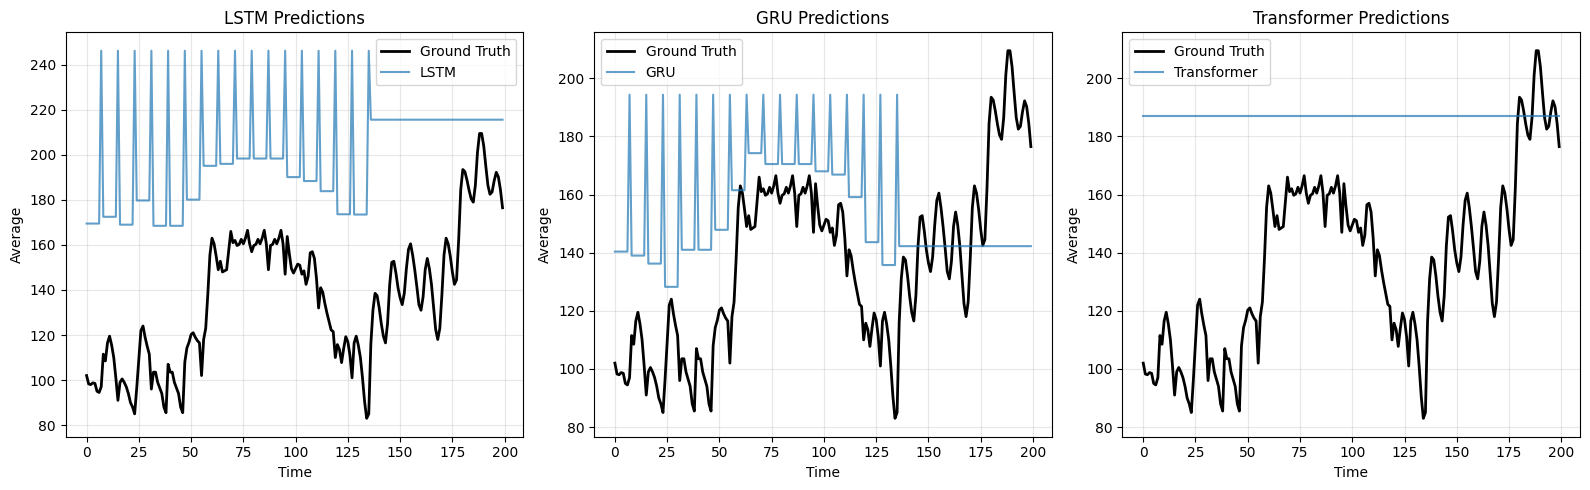

✓ Saved: /kaggle/working/imputation_comparison.png


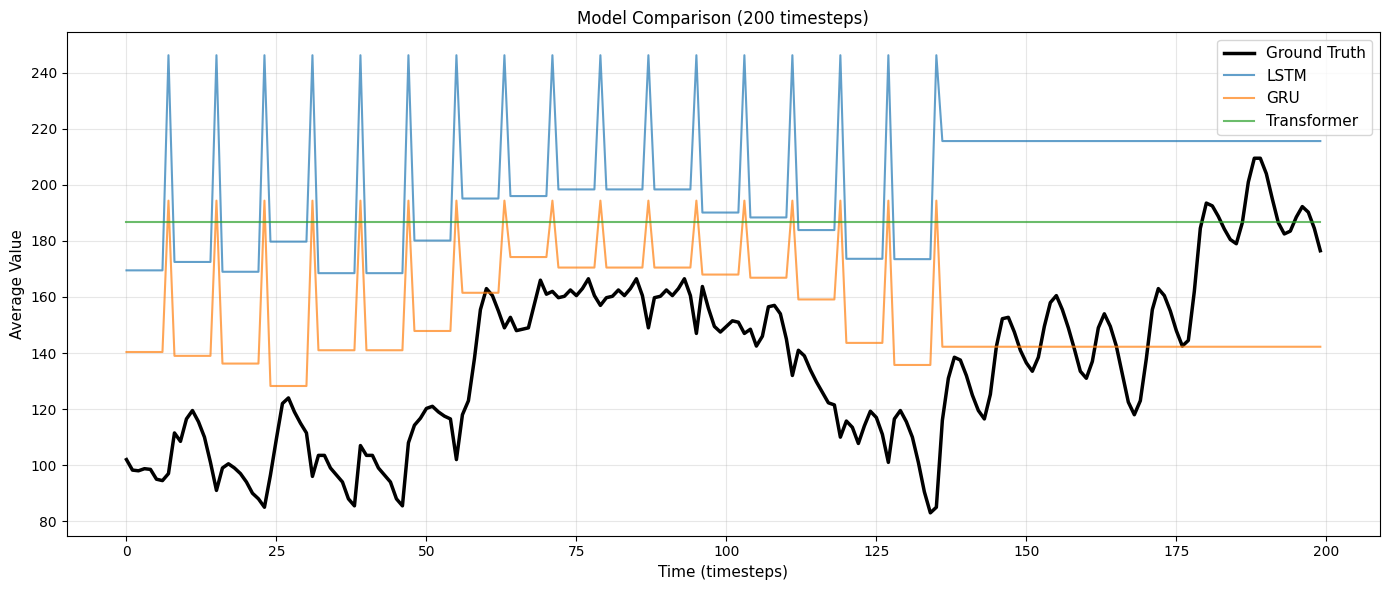

✓ Saved: /kaggle/working/imputation_metrics.png


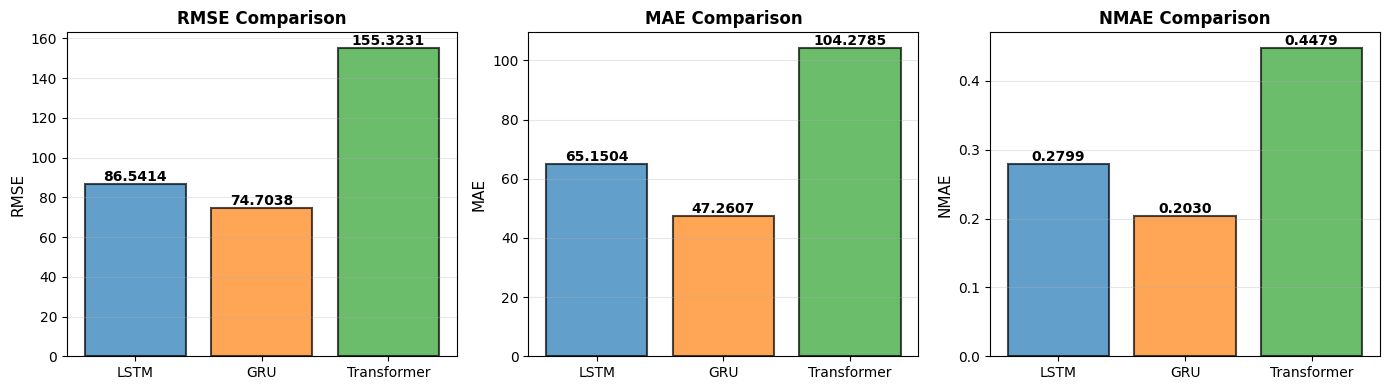

✓ Saved: /kaggle/working/results_summary.csv

PROJECT COMPLETED SUCCESSFULLY!

Generated outputs in /kaggle/working:
  ✓ imputation_predictions.png - Individual model predictions
  ✓ imputation_comparison.png - Combined model comparison
  ✓ imputation_metrics.png - Performance metrics comparison
  ✓ results_summary.csv - Results table
  ✓ edtwbi_cache.pkl - Cached eDTWBI context features


In [12]:
# ============================================================================
# CELL 9: COMPREHENSIVE RESULTS COMPARISON & VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("STEP 6: RESULTS SUMMARY & COMPARISON")
print("="*80)

results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'Transformer'],
    'RMSE': [rmse_lstm, rmse_gru, rmse_trans],
    'MAE': [mae_lstm, mae_gru, mae_trans],
    'NMAE': [nmae_lstm, nmae_gru, nmae_trans]
})

print("\n" + results_df.to_string(index=False))

best_model = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
print(f"\n✓ Best Model (lowest RMSE): {best_model}")

# Visualization 1: Time series predictions comparison
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(y_te_rescaled[:200], label='Ground Truth', c='k', linewidth=2)
plt.plot(y_pred_lstm_rescaled[:200], label='LSTM', alpha=0.7)
plt.legend(); plt.title('LSTM Predictions'); plt.xlabel('Time'); plt.ylabel('Average')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(y_te_rescaled[:200], label='Ground Truth', c='k', linewidth=2)
plt.plot(y_pred_gru_rescaled[:200], label='GRU', alpha=0.7)
plt.legend(); plt.title('GRU Predictions'); plt.xlabel('Time'); plt.ylabel('Average')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(y_te_rescaled[:200], label='Ground Truth', c='k', linewidth=2)
plt.plot(y_pred_trans_rescaled[:200], label='Transformer', alpha=0.7)
plt.legend(); plt.title('Transformer Predictions'); plt.xlabel('Time'); plt.ylabel('Average')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{CONFIG["output_path"]}/imputation_predictions.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CONFIG['output_path']}/imputation_predictions.png")
plt.show()

# Visualization 2: All models comparison
plt.figure(figsize=(14, 6))
plt.plot(y_te_rescaled[:200], label='Ground Truth', c='k', linewidth=2.5)
plt.plot(y_pred_lstm_rescaled[:200], label='LSTM', alpha=0.7, linewidth=1.5)
plt.plot(y_pred_gru_rescaled[:200], label='GRU', alpha=0.7, linewidth=1.5)
plt.plot(y_pred_trans_rescaled[:200], label='Transformer', alpha=0.7, linewidth=1.5)
plt.legend(fontsize=11); plt.title('Model Comparison (200 timesteps)', fontsize=12)
plt.xlabel('Time (timesteps)', fontsize=11); plt.ylabel('Average Value', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{CONFIG["output_path"]}/imputation_comparison.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CONFIG['output_path']}/imputation_comparison.png")
plt.show()

# Visualization 3: Metrics bar chart
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
models = ['LSTM', 'GRU', 'Transformer']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(['RMSE', 'MAE', 'NMAE']):
    values = results_df[metric].values
    axes[idx].bar(models, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(values):
        axes[idx].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{CONFIG["output_path"]}/imputation_metrics.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CONFIG['output_path']}/imputation_metrics.png")
plt.show()

# Save results to CSV
results_df.to_csv(f'{CONFIG["output_path"]}/results_summary.csv', index=False)
print(f"✓ Saved: {CONFIG['output_path']}/results_summary.csv")

print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nGenerated outputs in /kaggle/working:")
print("  ✓ imputation_predictions.png - Individual model predictions")
print("  ✓ imputation_comparison.png - Combined model comparison")
print("  ✓ imputation_metrics.png - Performance metrics comparison")
print("  ✓ results_summary.csv - Results table")
print("  ✓ edtwbi_cache.pkl - Cached eDTWBI context features")
